# Simple MNIST Handwritten digits detection

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.python.framework.graph_util import convert_variables_to_constants
import os

%matplotlib inline
mpl.rcParams['figure.dpi'] = 100

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Understand the MNIST dataset

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


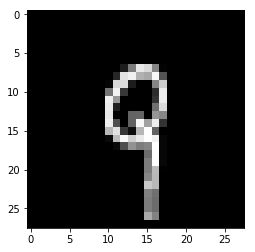

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
batch_xs, batch_ys = mnist.train.next_batch(1)
img = batch_xs[0].reshape([28, 28])
label = batch_ys[0]

plt.imshow(img, cmap="gray")
print(label)

## Define Model

![title](images/mnist_two_layers.png)

In [3]:
# 784 = 28x28 images
# None: We don't know how many items will be in this dimension
x = tf.placeholder(tf.float32, shape=[None, 784], name="input")
y_ = tf.placeholder(tf.float32, [None, 10])

# Weights and bias
# variables: we need to change this values when the model learns
fc1_W = tf.Variable(tf.truncated_normal([784, 10], stddev=0.1))
fc1_b = tf.Variable(tf.constant(0.1, shape=[10]))
fc1 = tf.nn.relu(tf.matmul(x, fc1_W) + fc1_b)

fc2_W = tf.Variable(tf.truncated_normal([10, 10], stddev=0.1))
fc2_b = tf.Variable(tf.constant(0.1, shape=[10]))

# define our model
y = tf.nn.softmax(tf.matmul(fc1, fc2_W) + fc2_b, name="output")

## Loss Function

In [4]:
# loss
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Loss Optimization
![title](images/optimization.png)

In [5]:
# loss optimization
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.5) \
    .minimize(cross_entropy)

## Learning Rate
![title](images/learning_rate.png)
![title](images/learning_rate_2.png)

## Define metrics

In [6]:
# What is correct
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# How accurate is it
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train the model

In [7]:
# Init all variables
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

# Train the model
num_steps = 3000
batch_size = 32
display_every = 200

for i in range(num_steps):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    if i % display_every == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch_xs, y_: batch_ys
        })
        print("Step {0}, training accuracy {1:.3f}%"
              .format(i, train_accuracy * 100))

Step 0, training accuracy 10.000%
Step 200, training accuracy 84.000%
Step 400, training accuracy 82.000%
Step 600, training accuracy 80.000%
Step 800, training accuracy 92.000%
Step 1000, training accuracy 96.000%
Step 1200, training accuracy 94.000%
Step 1400, training accuracy 98.000%
Step 1600, training accuracy 100.000%
Step 1800, training accuracy 88.000%
Step 2000, training accuracy 96.000%
Step 2200, training accuracy 100.000%
Step 2400, training accuracy 90.000%
Step 2600, training accuracy 94.000%
Step 2800, training accuracy 92.000%


## Validate results of the model

In [8]:
# accuracy on test data
validation_accuracy = accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels
})

print("Validation Accuracy: {0:.3f}%".format(validation_accuracy * 100))

Validation Accuracy: 91.360%


## Save model

In [9]:
if not os.path.exists("models"):
    os.makedirs("models")

graph_path = "models/tensorflow-simple_mnist.pb"
graph_path_text = "models/tensorflow-simple_mnist.pb.txt"

minimal_graph = convert_variables_to_constants(sess, sess.graph_def, ["output"])
tf.train.write_graph(minimal_graph, '.', graph_path, as_text=False)
tf.train.write_graph(minimal_graph, '.', graph_path_text, as_text=True)
    
sess.close()

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


## Predict an image from saved model

### Load graph

In [10]:
graph = tf.Graph()
graph_def = tf.GraphDef()

with open(graph_path, "rb") as f:
  graph_def.ParseFromString(f.read())
with graph.as_default():
  tf.import_graph_def(graph_def)

for op in graph.get_operations():
    print(str(op.name))

input_layer = "input"
output_layer = "output"

input_operation = graph.get_operation_by_name("import/" + input_layer)
output_operation = graph.get_operation_by_name("import/"+ output_layer)

import/input
import/Variable
import/Variable/read
import/Variable_1
import/Variable_1/read
import/MatMul
import/add
import/Relu
import/Variable_2
import/Variable_2/read
import/Variable_3
import/Variable_3/read
import/MatMul_1
import/add_1
import/output


### prepare image

(784,)
(28, 28)


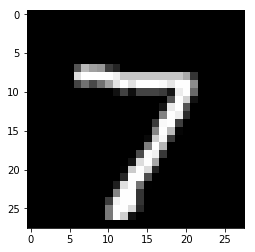

In [17]:
x = mnist.test.images[0]
print(x.shape)
x = np.expand_dims(x, axis=0)

# display image
img = x.reshape([28, 28])
print(img.shape)
plt.imshow(img, cmap="gray")

### Predict image

In [18]:
with tf.Session(graph=graph) as session:
  results = session.run(output_operation.outputs[0], {
      input_operation.outputs[0]: x
  })

predictions = results[0]
print(predictions)
np.argmax(predictions)

[1.0191884e-10 1.3174799e-17 3.7008646e-11 7.0597736e-07 6.4864994e-16
 7.2862286e-11 1.6200912e-22 9.9999928e-01 6.1715793e-12 2.7162086e-10]


7